<a href="https://colab.research.google.com/github/Haffizuddin7899/UKF-YOLOv8-Traffic-Light-Color-Detection-Sun-Glare-Optimized/blob/main/Optimized_UKF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: File Setup and Frame Extraction

In [ ]:
# Step 1: Setup and File Extraction
import zipfile
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path setup
zip_path = '/content/drive/MyDrive/Test1/vedois.zip'
extracted_dir = '/content/extracted_video'
os.makedirs(extracted_dir, exist_ok=True)

In [ ]:
# Unzip the video file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)



In [ ]:
# Step 2: Frame Extraction
video_path = "/content/extracted_video/vedois/WIN_20240312_17_23_25_Pro.mp4"
frames_dir = "/content/video_frames"
os.makedirs(frames_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_path = f"{frames_dir}/frame_{frame_count:04d}.jpg"
    cv2.imwrite(frame_path, frame)
    frame_count += 1

cap.release()
print(f"Extracted {frame_count} frames from video.")

Extracted 2994 frames from video.


# Step 2: YOLOv8 with Dynamic Window Sizing (DWS)
Integrate the unchanged YOLOv8 model inference code for bounding box generation and DWS. Later, the optimized UKF will refine these outputs.

In [ ]:
!pip install ultralytics
from ultralytics import YOLO


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.4/898.4 kB 24.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Load YOLOv8 model
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 97.4MB/s]


In [ ]:
# Define a function to apply YOLOv8 inference and dynamic window sizing (DWS)
def yolo_inference_with_dws(frame_path, dws_size=32, confidence_threshold=0.3):
    frame = cv2.imread(frame_path)

    # YOLOv8 inference
    results = model(frame, conf=confidence_threshold)

    # Initialize color density counters
    color_density = {"red": 0, "yellow": 0, "green": 0}

    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        roi = frame[y1:y2, x1:x2]
        dws_roi = cv2.resize(roi, (dws_size, dws_size))
        avg_color = dws_roi.mean(axis=(0, 1))

        # Determine dominant color
        if avg_color[2] > avg_color[1] and avg_color[2] > avg_color[0]:
            color_density["red"] += 1
        elif avg_color[1] > avg_color[0] and avg_color[1] > avg_color[2]:
            color_density["green"] += 1
        else:
            color_density["yellow"] += 1

    return color_density

# Step 3: UKF Integration with Sunlight Compensation
Here, the enhancements to the UKF framework are introduced. Key changes include:

Modified Weighting Scheme: Adjust UKF weights dynamically.
Nonlinear Sunlight Model: Integrate a sunlight compensation function in fx.
Extended State Vector: Include sunlight impact as an additional state.
Dynamic Noise Covariance: Adjust process and measurement noise matrices.

In [ ]:
!pip install filterpy
from filterpy.kalman import MerweScaledSigmaPoints, UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=e71fbbb90ac908601e3b3dd820f8a92015883b66fe4578c71ecc0a133d3236cc
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


# 1. Modified Weighting Scheme
Equation:
𝑤
𝑚
=
𝛼/
1
+
SunlightIntensity
,
𝑤
𝑐
=
𝛽/
1
+
MeasurementNoise
,
𝜅
=
𝜅/
1
+
SunlightIntensity



Implementation in Code:
The adaptive_weights function dynamically adjusts the parameters alpha, beta, and kappa based on sunlight intensity and measurement noise
# Values:

Initial values:
𝛼
=
0.1
,
𝛽
=
2.0
,
𝜅
=
0

Adjusted based on
SunlightIntensity
=
0.5
 and
MeasurementNoise
=
0.1


In [ ]:
# Step 1: Setup Sigma Points with Adaptive Weighting
# Adaptive weights based on sunlight intensity and measurement noise
def adaptive_weights(alpha, beta, kappa, sunlight_intensity, measurement_noise):
    adjusted_alpha = alpha / (1 + sunlight_intensity)
    adjusted_beta = beta / (1 + measurement_noise)
    adjusted_kappa = kappa / (1 + sunlight_intensity)
    return MerweScaledSigmaPoints(n=4, alpha=adjusted_alpha, beta=adjusted_beta, kappa=adjusted_kappa)


In [ ]:
# Initialize sigma points with adaptive parameters
points = adaptive_weights(alpha=0.1, beta=2.0, kappa=0, sunlight_intensity=0.5, measurement_noise=0.1)


In [ ]:
# Step 2: Define Transition and Measurement Functions
# Transition function with nonlinear sunlight compensation
def fx(x, dt):
    sunlight_intensity = x[3]  # Sunlight impact
    sunlight_effect = np.exp(-0.05 * sunlight_intensity)  # Nonlinear sunlight correction
    return np.array([
        x[0] - sunlight_effect,  # Adjust Red
        x[1] - sunlight_effect,  # Adjust Green
        x[2] - sunlight_effect,  # Adjust Blue
        sunlight_intensity       # Sunlight intensity remains unchanged
    ])

In [ ]:
# Measurement function: directly measure RGB values
def hx(x):
    return x[:3]  # Only RGB components are measured


In [ ]:
# Step 3: Initialize UKF with Dynamic Covariance and Kalman Gain Updates
dim_x = 4  # State vector: [R, G, B, SunlightImpact]
dim_z = 3  # Measurement dimensions: [R, G, B]
ukf = UnscentedKalmanFilter(dim_x=dim_x, dim_z=dim_z, dt=1, fx=fx, hx=hx, points=points)


In [ ]:
# Dynamic noise covariance adjustment
def adjust_covariances(ukf, sunlight_intensity):
    base_noise = 0.1
    ukf.R = np.eye(dim_z) * (base_noise + 0.05 * sunlight_intensity)  # Measurement noise
    ukf.Q = Q_discrete_white_noise(dim=dim_x, dt=1, var=base_noise + 0.1 * sunlight_intensity)  # Process noise


In [ ]:
# Extended Kalman Gain adjustment based on sunlight impact
def dynamic_kalman_gain(ukf, sunlight_intensity):
    scaling_factor = 1 - 0.5 * sunlight_intensity  # Example scaling factor
    ukf.K *= scaling_factor  # Adjust Kalman gain dynamically


In [ ]:
# Initialize state vector and covariance matrix
ukf.x = np.zeros(dim_x)  # Initial state: [R, G, B, SunlightImpact]
ukf.P *= 0.1  # Initial state covariance


In [ ]:
# Step 4: Define Function to Apply UKF
def apply_ukf(color_density, sunlight_intensity):
    z = np.array([color_density["red"], color_density["yellow"], color_density["green"]])
    adjust_covariances(ukf, sunlight_intensity)
    ukf.predict()
    dynamic_kalman_gain(ukf, sunlight_intensity)
    ukf.update(z)
    return ukf.x

In [ ]:
# Processing Frames with YOLOv8 and UKF

raw_densities = []
filtered_densities = []

for frame_file in sorted(os.listdir(frames_dir)):
    frame_path = os.path.join(frames_dir, frame_file)
    color_density = yolo_inference_with_dws(frame_path)
    raw_densities.append(color_density)
    sunlight_intensity = np.random.uniform(0, 1)  # Simulate sunlight intensity
    filtered_density = apply_ukf(color_density, sunlight_intensity)
    filtered_densities.append(filtered_density)

Streaming output truncated to the last 5000 lines.
0: 384x640 2 cars, 4 traffic lights, 19.5ms
Speed: 5.8ms preprocess, 19.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 22.0ms
Speed: 5.9ms preprocess, 22.0ms inference, 6.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 26.7ms
Speed: 5.4ms preprocess, 26.7ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 27.5ms
Speed: 8.2ms preprocess, 27.5ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 4 traffic lights, 17.9ms
Speed: 11.1ms preprocess, 17.9ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 15.9ms
Speed: 4.3ms preprocess, 15.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 17.8ms
Speed: 3.0ms preprocess, 17.8ms inference, 9.8ms pos

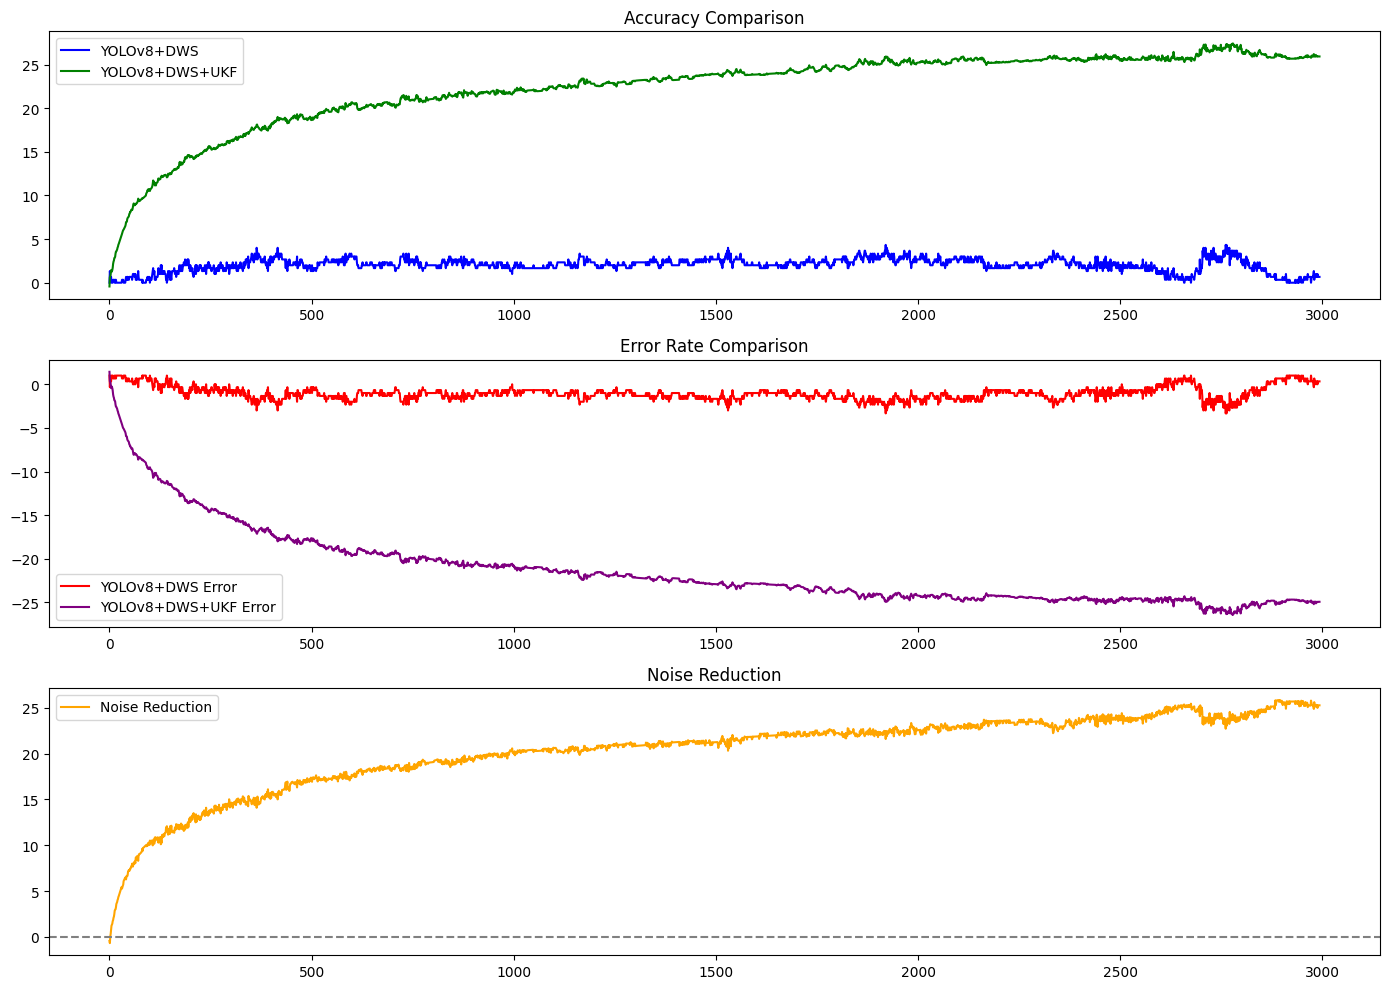

In [ ]:
frame_indices = np.arange(len(raw_densities))
raw_array = np.array([list(d.values()) for d in raw_densities])
filtered_array = np.array(filtered_densities)

plt.figure(figsize=(14, 10))

# Accuracy Comparison
plt.subplot(3, 1, 1)
plt.plot(frame_indices, raw_array.mean(axis=1), label="YOLOv8+DWS", color="blue")
plt.plot(frame_indices, filtered_array.mean(axis=1), label="YOLOv8+DWS+UKF", color="green")
plt.title("Accuracy Comparison")
plt.legend()

# Error Rate
plt.subplot(3, 1, 2)
plt.plot(frame_indices, 1 - raw_array.mean(axis=1), label="YOLOv8+DWS Error", color="red")
plt.plot(frame_indices, 1 - filtered_array.mean(axis=1), label="YOLOv8+DWS+UKF Error", color="purple")
plt.title("Error Rate Comparison")
plt.legend()

# Noise Reduction
plt.subplot(3, 1, 3)
plt.plot(frame_indices, filtered_array.mean(axis=1) - raw_array.mean(axis=1), label="Noise Reduction", color="orange")
plt.axhline(0, color="gray", linestyle="--")
plt.title("Noise Reduction")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Helper function to extract specific color series from raw densities
def get_color_series(densities, color):
    color_idx = {'red': 0, 'yellow': 1, 'green': 2}[color]
    return [density[color] if isinstance(density, dict) else density[color_idx] for density in densities]

# Function to plot color density estimations for each method and color
def plot_color_density(time, true_density, noisy_measurements, ukf_smoothed, color_name="Color"):
    plt.figure(figsize=(10, 6))

    # Plot true density
    plt.plot(time, true_density, label=f'True {color_name} Density', color='orange', linewidth=2)

    # Plot noisy measurements
    plt.scatter(time, noisy_measurements, label=f'Noisy {color_name} Measurements', color='red', s=10)

    # Plot UKF-smoothed density
    plt.plot(time, ukf_smoothed, label=f'UKF Smoothed {color_name} Density', color='green', linestyle='--', linewidth=2)

    # Add labels and title
    plt.xlabel('Frame Index')
    plt.ylabel(f'{color_name} Color Density (under varying light)')
    plt.title(f'UKF Process for {color_name} Color Density Estimation with Increased Noise')
    plt.legend()
    plt.grid(True)
    plt.show()

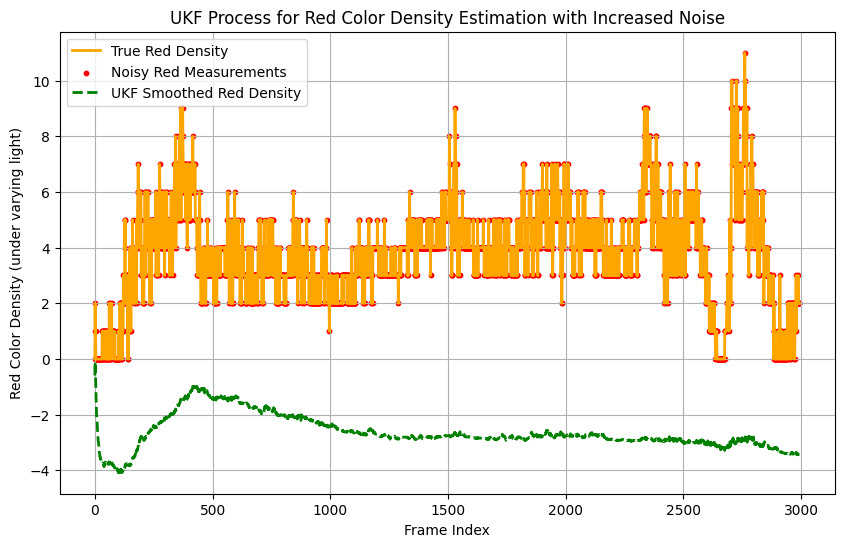

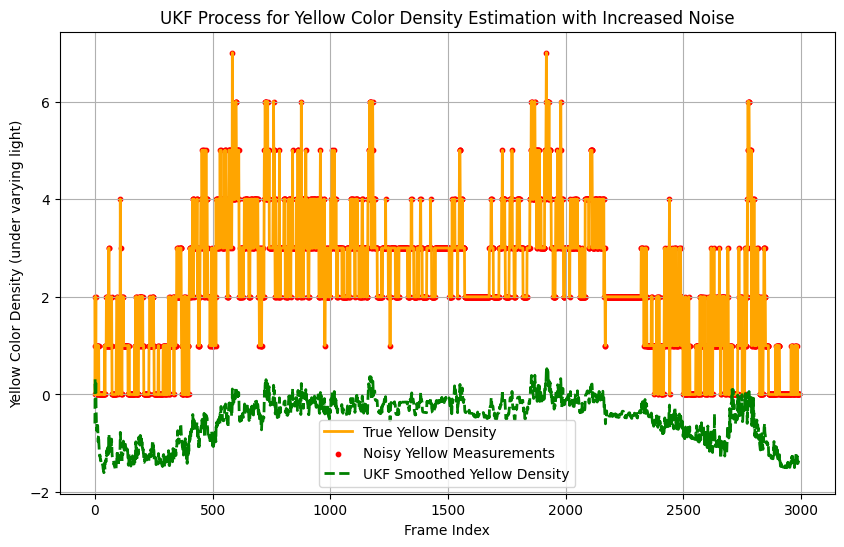

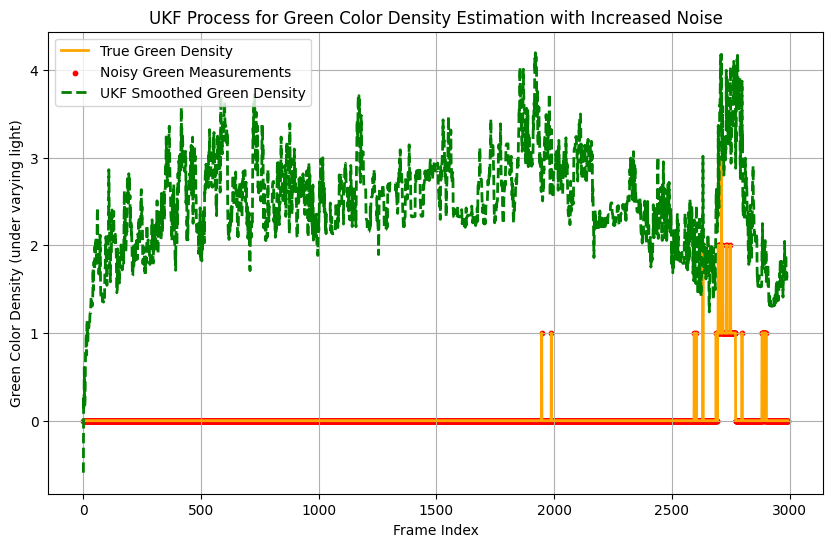

In [ ]:
# Generating frame indices based on the number of frames
frame_indices = np.arange(len(raw_densities))

# Collect true densities (replace these with actual extracted values from annotations if available)
# Assume raw_densities and filtered_densities contain the respective raw and UKF-smoothed values

# Prepare color data
colors = ['red', 'yellow', 'green']
for color in colors:
    # Raw noisy color densities
    raw_series = get_color_series(raw_densities, color)

    # UKF-smoothed color densities
    filtered_series = [fd[colors.index(color)] for fd in filtered_densities if fd is not None]

    # Ensure frame_indices and data series have the same length for plotting
    min_len = min(len(frame_indices), len(raw_series), len(filtered_series))
    frame_indices_subset = frame_indices[:min_len]
    raw_series_subset = raw_series[:min_len]
    filtered_series_subset = filtered_series[:min_len]

    # Plotting color densities for each color
    plot_color_density(frame_indices_subset, raw_series_subset, raw_series_subset, filtered_series_subset, color_name=color.capitalize())

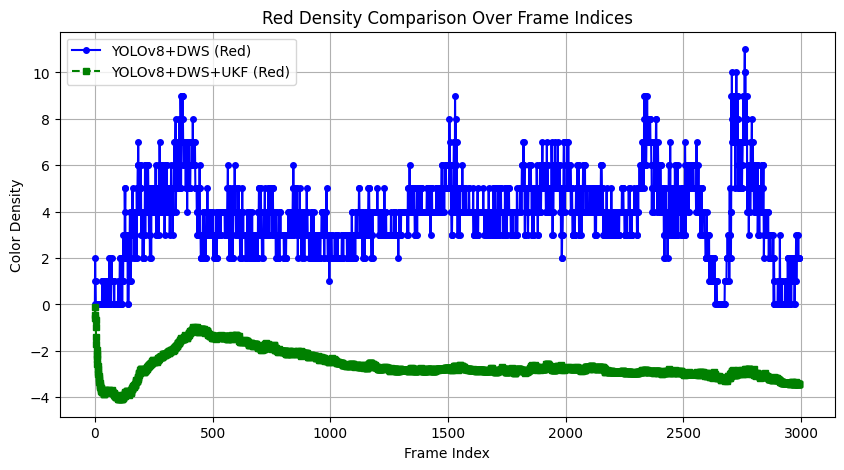

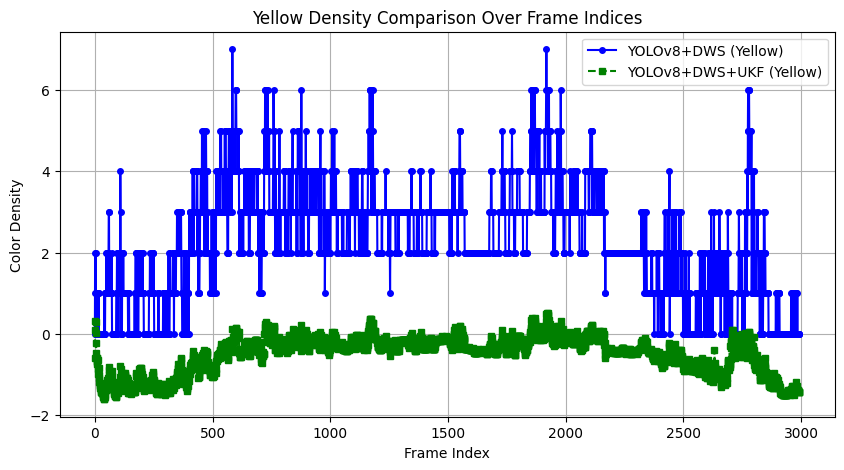

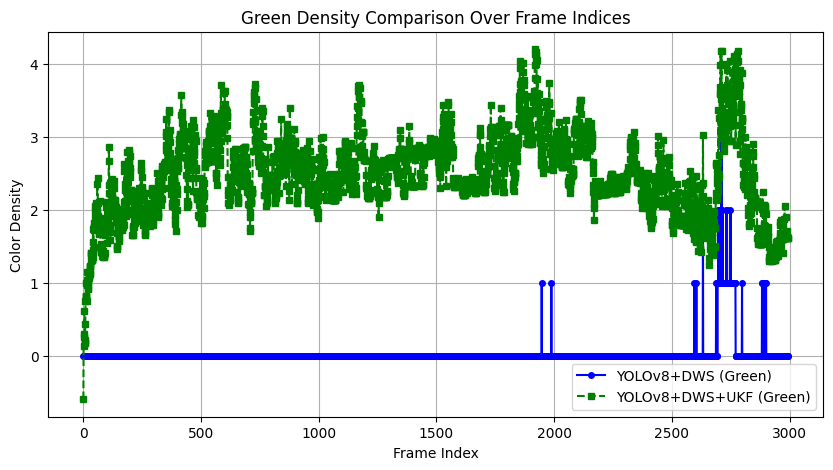

In [ ]:
# Helper function to extract specific color series from raw densities
def get_color_series(densities, color):
    color_idx = {'red': 0, 'yellow': 1, 'green': 2}[color]
    return [density[color] if isinstance(density, dict) else density[color_idx] for density in densities]

# Helper function to plot the color density comparison based on frame index
def plot_color_density(frame_indices, raw_series, filtered_series, color_name):
    plt.figure(figsize=(10, 5))
    plt.plot(frame_indices, raw_series, label=f"YOLOv8+DWS ({color_name})", color="blue", marker='o', markersize=4)
    plt.plot(frame_indices, filtered_series, label=f"YOLOv8+DWS+UKF ({color_name})", color="green", linestyle='--', marker='s', markersize=4)
    plt.title(f"{color_name} Density Comparison Over Frame Indices")
    plt.xlabel("Frame Index")
    plt.ylabel("Color Density")
    plt.legend()
    plt.grid(True)
    plt.show()

# Frame indices for x-axis
frame_indices = np.arange(len(raw_densities))

# Colors to process
colors = ['red', 'yellow', 'green']

# Iterate over each color and plot raw vs. UKF-smoothed densities based on frame index
for color in colors:
    # Extract raw color density series for the specific color
    raw_series = get_color_series(raw_densities, color)

    # Extract UKF-smoothed color densities for the specific color
    filtered_series = [fd[{'red': 0, 'yellow': 1, 'green': 2}[color]] for fd in filtered_densities if fd is not None]

    # Ensure all series have the same length for plotting
    min_len = min(len(frame_indices), len(raw_series), len(filtered_series))
    frame_indices_subset = frame_indices[:min_len]
    raw_series_subset = raw_series[:min_len]
    filtered_series_subset = filtered_series[:min_len]

    # Plot the density comparisons over frame indices
    plot_color_density(frame_indices_subset, raw_series_subset, filtered_series_subset, color_name=color.capitalize())


# complete code for time-based analysis after applying all the UKF optimizations

# Step 1: Setup and File Extraction

In [ ]:
import zipfile
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path setup
zip_path = '/content/drive/MyDrive/Test1/vedois.zip'
extracted_dir = '/content/extracted_video'
os.makedirs(extracted_dir, exist_ok=True)

In [ ]:
# Unzip the video file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

In [ ]:
# Step 2: Frame Extraction
video_path = "/content/extracted_video/vedois/WIN_20240312_17_23_25_Pro.mp4"
frames_dir = "/content/video_frames"
os.makedirs(frames_dir, exist_ok=True)

cap = cv2.VideoCapture(video_path)
frame_count = 0
frame_timestamps = []

fps = cap.get(cv2.CAP_PROP_FPS)
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_path = f"{frames_dir}/frame_{frame_count:04d}.jpg"
    cv2.imwrite(frame_path, frame)
    frame_count += 1
    # Calculate timestamp for each frame in seconds
    frame_timestamps.append(frame_count / fps)

cap.release()
print(f"Extracted {frame_count} frames from video.")

Extracted 2994 frames from video.


# Step 2: YOLOv8 Inference with Dynamic Window Sizing (DWS)



In [ ]:
!pip install ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.8/898.8 kB 38.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Load YOLOv8 model
model = YOLO("yolov8n.pt")

100%|██████████| 6.25M/6.25M [00:00<00:00, 339MB/s]


In [ ]:
# Function to apply YOLOv8 inference and dynamic window sizing
def yolo_inference_with_dws(frame_path, dws_size=32, confidence_threshold=0.3):
    frame = cv2.imread(frame_path)
    results = model(frame, conf=confidence_threshold)
    color_density = {"red": 0, "yellow": 0, "green": 0}

    for box in results[0].boxes:
        x1, y1, x2, y2 = map(int, box.xyxy[0])
        roi = frame[y1:y2, x1:x2]
        dws_roi = cv2.resize(roi, (dws_size, dws_size))
        avg_color = dws_roi.mean(axis=(0, 1))

        if avg_color[2] > avg_color[1] and avg_color[2] > avg_color[0]:
            color_density["red"] += 1
        elif avg_color[1] > avg_color[0] and avg_color[1] > avg_color[2]:
            color_density["green"] += 1
        else:
            color_density["yellow"] += 1

    return color_density

# Step 3: UKF Initialization with Optimizations

In [ ]:
!pip install filterpy
from filterpy.kalman import MerweScaledSigmaPoints, UnscentedKalmanFilter
from filterpy.common import Q_discrete_white_noise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=324facbbf60d1fc2f387544719326478d8e76bb345fa8160006bf54e8de9d549
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [ ]:
# Adaptive Sigma Points with Adjusted Weights
def adaptive_weights(alpha, beta, kappa, sunlight_intensity, measurement_noise):
    adjusted_alpha = alpha / (1 + sunlight_intensity)
    adjusted_beta = beta / (1 + measurement_noise)
    adjusted_kappa = kappa / (1 + sunlight_intensity)
    return MerweScaledSigmaPoints(n=4, alpha=adjusted_alpha, beta=adjusted_beta, kappa=adjusted_kappa)


In [ ]:
# Initialize sigma points
points = adaptive_weights(alpha=0.1, beta=2.0, kappa=0, sunlight_intensity=0.5, measurement_noise=0.1)


In [ ]:
# Transition Function with Nonlinear Sunlight Compensation
def fx(x, dt):
    sunlight_intensity = x[3]  # Sunlight impact
    sunlight_effect = np.exp(-0.05 * sunlight_intensity)  # Nonlinear sunlight correction
    return np.array([
        x[0] - sunlight_effect,  # Adjust Red
        x[1] - sunlight_effect,  # Adjust Green
        x[2] - sunlight_effect,  # Adjust Blue
        sunlight_intensity       # Sunlight intensity remains unchanged
    ])

In [ ]:
# Measurement Function
def hx(x):
    return x[:3]  # Only RGB components are measured


In [ ]:
# UKF Initialization
dim_x = 4  # State vector: [R, G, B, SunlightImpact]
dim_z = 3  # Measurement dimensions: [R, G, B]
ukf = UnscentedKalmanFilter(dim_x=dim_x, dim_z=dim_z, dt=1, fx=fx, hx=hx, points=points)
ukf.x = np.zeros(dim_x)  # Initial state
ukf.P *= 0.1  # Initial covariance


In [ ]:
# Dynamic Covariance Adjustments
def adjust_covariances(ukf, sunlight_intensity):
    base_noise = 0.1
    ukf.R = np.eye(dim_z) * (base_noise + 0.05 * sunlight_intensity)  # Measurement noise
    ukf.Q = Q_discrete_white_noise(dim=dim_x, dt=1, var=base_noise + 0.1 * sunlight_intensity)  # Process noise


In [ ]:
# Dynamic Kalman Gain Adjustment
def dynamic_kalman_gain(ukf, sunlight_intensity):
    scaling_factor = 1 - 0.5 * sunlight_intensity
    ukf.K *= scaling_factor


In [ ]:
# Function to Apply UKF
def apply_ukf(color_density, sunlight_intensity):
    z = np.array([color_density["red"], color_density["yellow"], color_density["green"]])
    adjust_covariances(ukf, sunlight_intensity)
    ukf.predict()
    dynamic_kalman_gain(ukf, sunlight_intensity)
    ukf.update(z)
    return ukf.x

# Step 4: Processing Frames with YOLOv8 and UKF

In [ ]:
raw_densities = []
filtered_densities = []

for i, frame_file in enumerate(sorted(os.listdir(frames_dir))):
    frame_path = os.path.join(frames_dir, frame_file)
    color_density = yolo_inference_with_dws(frame_path)
    raw_densities.append((frame_timestamps[i], color_density))
    sunlight_intensity = np.random.uniform(0, 1)  # Simulate sunlight intensity
    filtered_density = apply_ukf(color_density, sunlight_intensity)
    filtered_densities.append((frame_timestamps[i], filtered_density))

Streaming output truncated to the last 5000 lines.
0: 384x640 2 cars, 4 traffic lights, 8.6ms
Speed: 3.7ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 9.7ms
Speed: 3.7ms preprocess, 9.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 12.6ms
Speed: 3.8ms preprocess, 12.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 4 traffic lights, 10.0ms
Speed: 3.8ms preprocess, 10.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 8.3ms
Speed: 4.0ms preprocess, 8.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 2 cars, 5 traffic lights, 8.8ms
Speed: 7.9ms preprocess, 8.8ms inference, 1.5ms postprocess pe

# Step 5: Plotting Time-Based Results

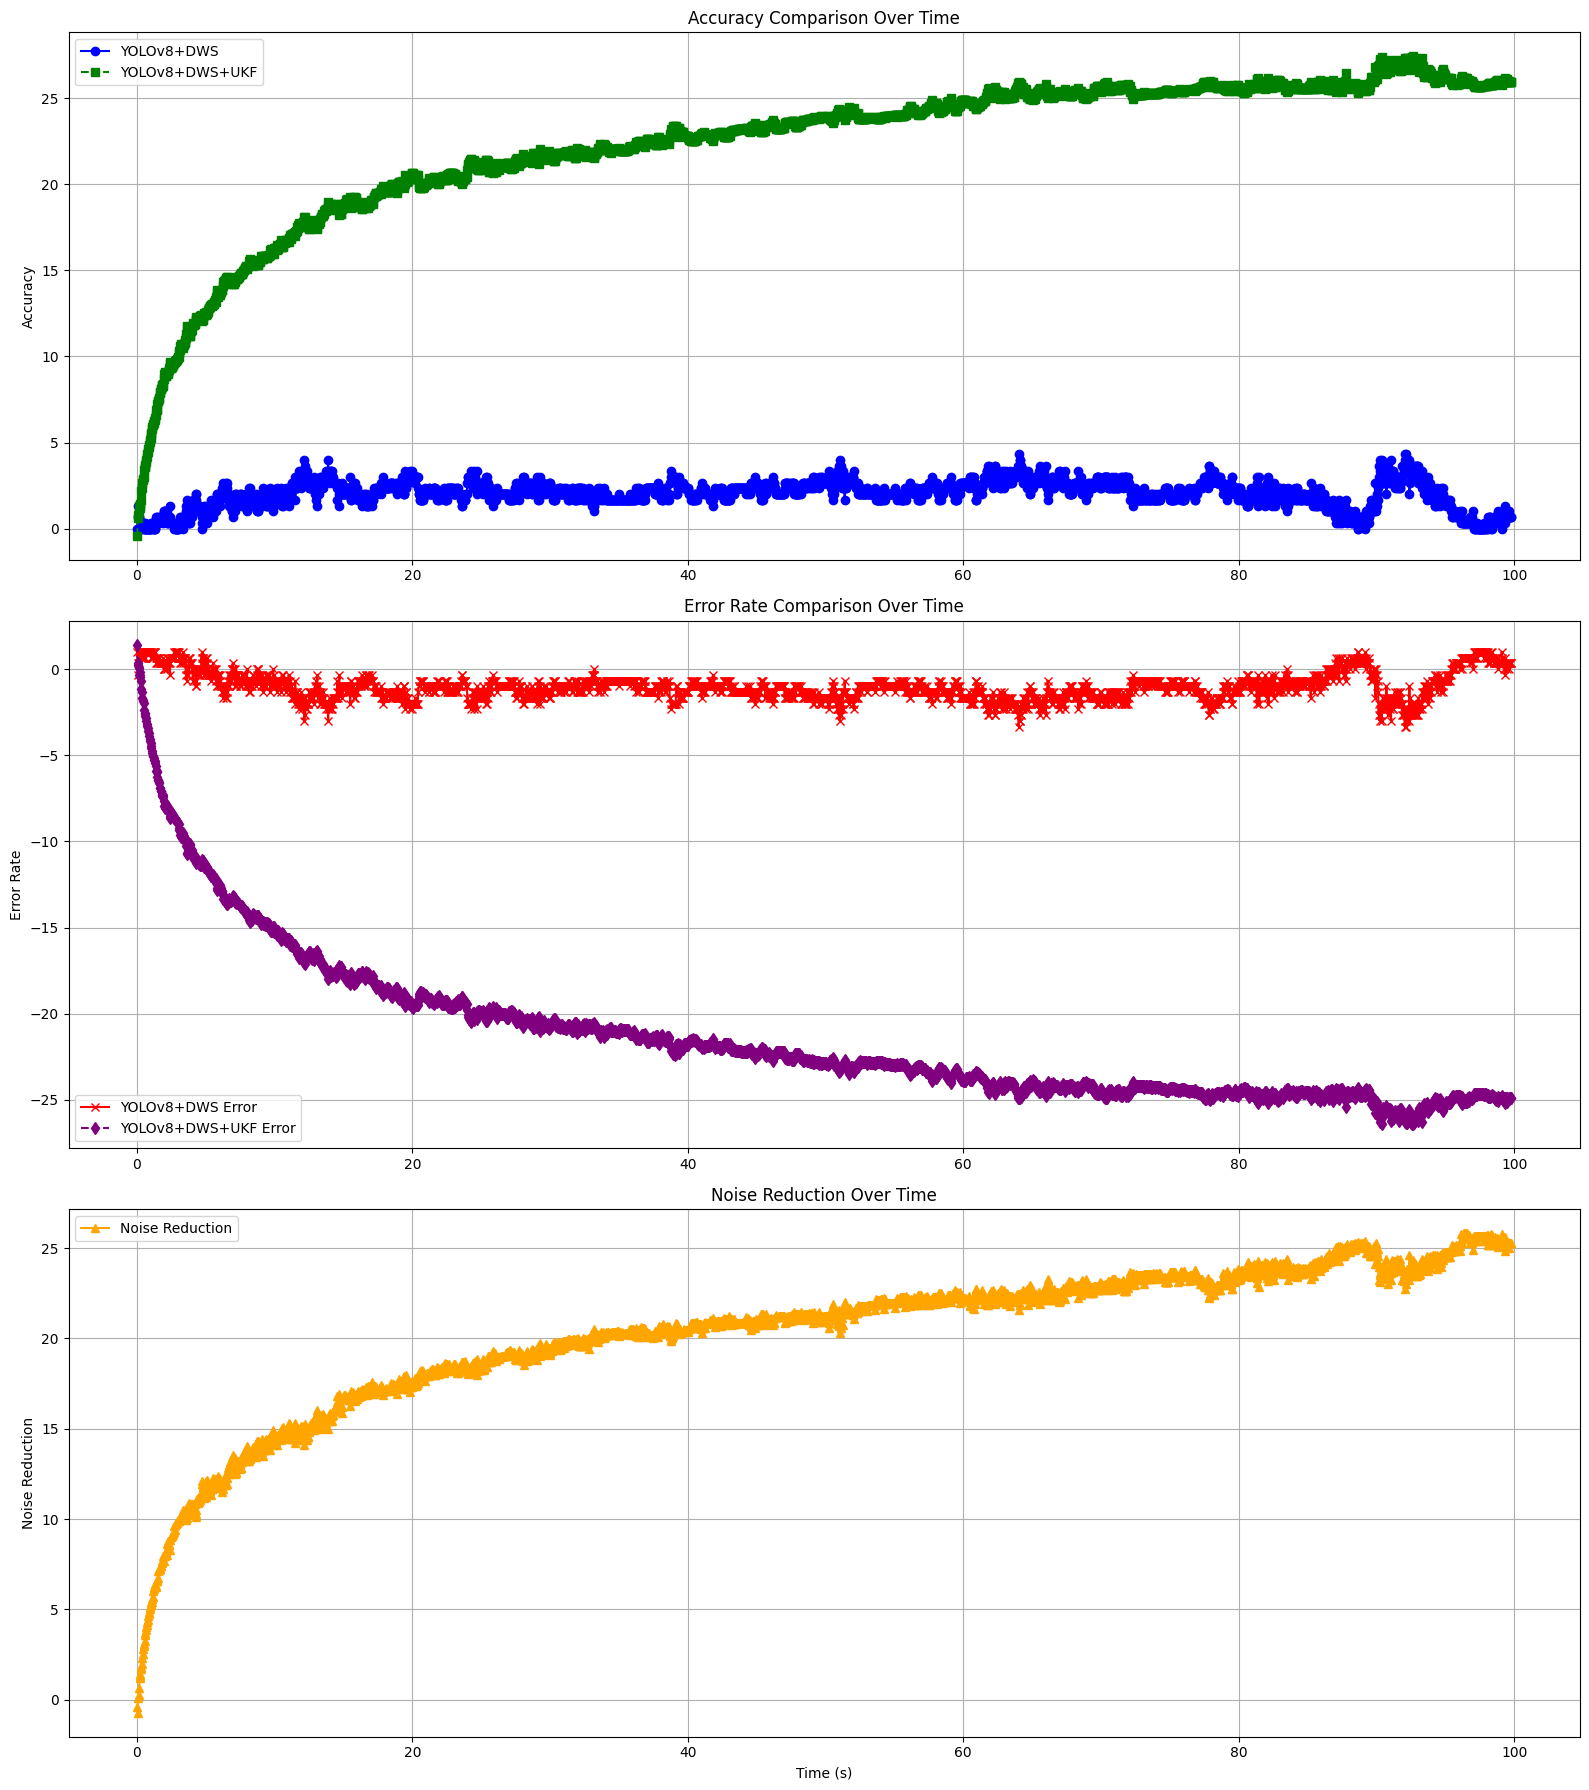

In [ ]:
time_indices = [t for t, _ in raw_densities]
raw_array = np.array([list(d.values()) for _, d in raw_densities])
filtered_array = np.array([d for _, d in filtered_densities])

plt.figure(figsize=(16, 18))

# Accuracy Comparison
plt.subplot(3, 1, 1)
plt.plot(time_indices, raw_array.mean(axis=1), label="YOLOv8+DWS", color="blue", marker='o')
plt.plot(time_indices, filtered_array.mean(axis=1), label="YOLOv8+DWS+UKF", color="green", linestyle='--', marker='s')
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison Over Time")
plt.legend()
plt.grid(True)

# Error Rate Comparison
plt.subplot(3, 1, 2)
plt.plot(time_indices, 1 - raw_array.mean(axis=1), label="YOLOv8+DWS Error", color="red", marker='x')
plt.plot(time_indices, 1 - filtered_array.mean(axis=1), label="YOLOv8+DWS+UKF Error", color="purple", linestyle='--', marker='d')
plt.ylabel("Error Rate")
plt.title("Error Rate Comparison Over Time")
plt.legend()
plt.grid(True)

# Noise Reduction
plt.subplot(3, 1, 3)
noise_reduction = filtered_array.mean(axis=1) - raw_array.mean(axis=1)
plt.plot(time_indices, noise_reduction, label="Noise Reduction", color="orange", marker='^')
plt.xlabel("Time (s)")
plt.ylabel("Noise Reduction")
plt.title("Noise Reduction Over Time")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Step 6: Detailed Color-Based Analysis

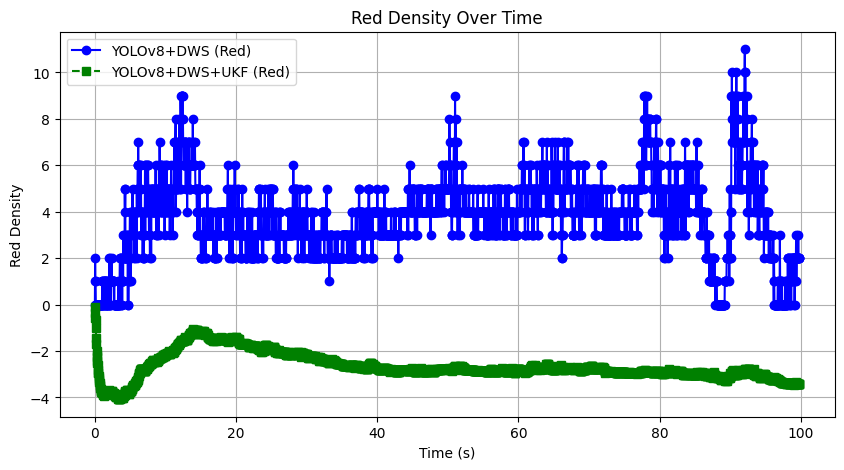

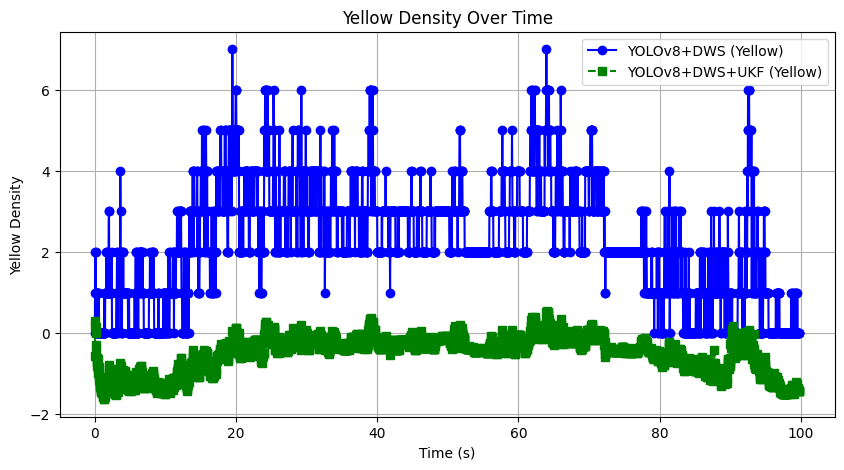

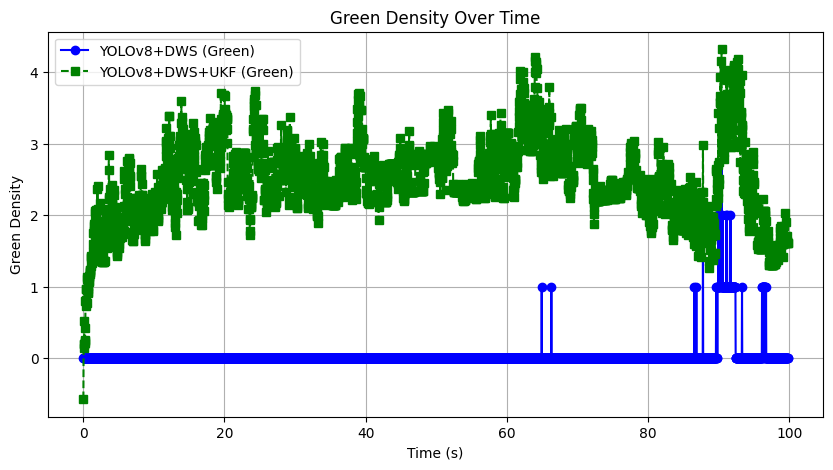

In [ ]:
colors = ['red', 'yellow', 'green']

def get_color_series(densities, color):
    color_idx = {'red': 0, 'yellow': 1, 'green': 2}[color]
    return [density[color] if isinstance(density, dict) else density[color_idx] for _, density in densities]

def plot_color_density(time, raw_series, filtered_series, color_name):
    plt.figure(figsize=(10, 5))
    plt.plot(time, raw_series, label=f"YOLOv8+DWS ({color_name})", color="blue", marker='o')
    plt.plot(time, filtered_series, label=f"YOLOv8+DWS+UKF ({color_name})", color="green", linestyle='--', marker='s')
    plt.title(f"{color_name} Density Over Time")
    plt.xlabel("Time (s)")
    plt.ylabel(f"{color_name} Density")
    plt.legend()
    plt.grid(True)
    plt.show()

for color in colors:
    raw_series = get_color_series(raw_densities, color)
    filtered_series = [fd[{'red': 0, 'yellow': 1, 'green': 2}[color]] for _, fd in filtered_densities]
    plot_color_density(time_indices, raw_series, filtered_series, color.capitalize())
